In [1]:
#Libraries
using Gen
using PyPlot
using Distributions
using LinearAlgebra
using Flux
using Random
using Distances;

In [51]:
#------------------------------------
#Hyperparameters and Helper Functions
#------------------------------------

#Select Network Goal
network = "classifier"
#network = "interpolator"

#Data hyperparameters
n = 20 #Number of samples per mode (classifier)
m = 4 #Number of modes (classifier)
d = 2 #Input dimension
N = n*m #Total samples
σₐ = 0.02 #Mode variance (classifier)
#bound = 1.0 #Axis bound

#Network hyperparameters
α = 6 #Gamma Scale for Hyperparameters

#Node hyperparameters
k_range = 12 #Maximum number of neurons per layer
k_list = [Int(i) for i in 1:k_range]
k_real = 2

#Layer hyperparameters
l_range = 1 #Maximum number of layers in the network
l_list = [Int(i) for i in 1:l_range]
l_real = 1

#Helper Functions
function plot_data(data,classes,alpha=1.0)
    markers = ["o","*"]
    colors = ["blue","green"]
    for i=1:2
        mask = [classes[j] == i for j in 1:length(classes)]
        scatter(data[:,1][mask],data[:,2][mask],c=colors[i],alpha=alpha,marker=markers[i],zorder=3)
    end
end;

function data_labeller(y::Array{Float64})
    labels = [y[i] > 0.5 ? 2 : 1 for i=1:length(y)]
    return labels
end

function trace_acc(trace)
    pred_y = G(x, trace)
    pred_labels = data_labeller(pred_y)
    acc = sum([classes[i] == pred_labels[i] for i=1:length(classes)])
    return acc
end

mₖ(k) = k*4 + 1;

function layer_unpacker(i,l,k)
    if i == 1
        input_dim = d
        output_dim = k[i]
    else
        input_dim = k[i-1]
        output_dim = k[i]
    end
    return input_dim, output_dim
end;

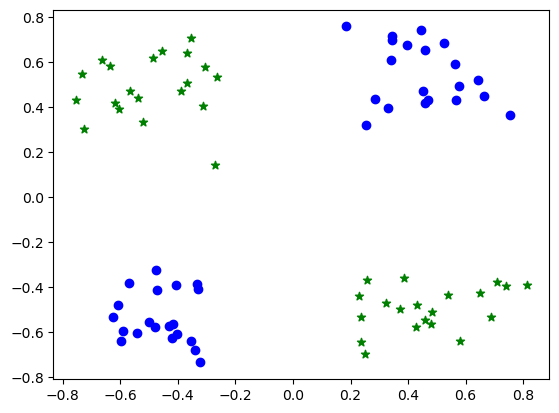

In [52]:
#Generate XOR Data
function real_data(N::Int, modes::Int, σ::Float64)
    μ₁ = [-0.5, -0.5]
    μ₂ = [-0.5, 0.5]
    μ₃ = [0.5, 0.5]
    μ₄ = [0.5, -0.5]
    #μ₅ = [1.25, 1.25]
    #μ₆ = [1.25, 1.75]
    #μ₇ = [1.75, 1.75]
    #μ₈ = [1.75, 1.25]
    μ = [μ₁, μ₂, μ₃, μ₄]
    Σ = [[σ, 0] [0, σ]]
    
    all_samples = zeros(Float64, (N*modes, 2))
    classes = zeros(Int, (N*modes))
    
    for i = 1:modes
        dist = MvNormal(μ[i], Σ)
        sample = rand(dist, N)::Matrix
        #scatter(sample[1,:],sample[2,:])
        all_samples[(i-1)*N+1:i*N,:] = transpose(sample)
        classes[(i-1)*N+1:i*N] = fill(i, N)
        classes = float(classes)
    end
    return all_samples, classes
end
    
x_raw, classes = real_data(Int(N/4), 4, σₐ);
classes = [(i+1) % 2 + 1 for i in classes]
y_real = classes

plot_data(x_raw,classes)
x = transpose(x_raw)
size(x);

In [53]:
#Bayesian Neural Net
function G(x, trace)
    activation = relu
    layers = trace[:l]
    ks = [trace[(:k,i)] for i=1:layers]
    for i=1:layers
        in_dim, out_dim = layer_unpacker(i, layers, ks)
        W = reshape(trace[(:W,i)], out_dim, in_dim)
        b = reshape(trace[(:b,i)], trace[(:k,i)])
        nn = Dense(W, b, activation)
        x = nn(x)
    end
    
    Wₒ = reshape(trace[(:W,layers+1)], 1, ks[layers])
    bₒ = reshape(trace[(:b,layers+1)], 1)
    
    nn_out = Dense(Wₒ, bₒ)
    return nn_out(x)
end;

@gen function classifier(x::Array{Float64})
    
    #Create a blank choicemap
    obs = choicemap()::ChoiceMap
    
    #Draw number of layers
    l ~ categorical([1/length(l_list) for i=1:length(l_list)])
    l_real = l
    obs[:l] = l
    
    #Create individual weight and bias vectors
    #Loop through hidden layers
    k = [Int(0) for i=1:l+1]
    for i=1:l
        k[i] = @trace(categorical([1/length(k_list) for i=1:length(k_list)]), (:k,i))
        obs[(:k,i)] = k[i]
    end
    k[l+1] = @trace(categorical([1.0]), (:k,l+1))
    obs[(:k,l+1)] = k[l+1]
    
    α = 0.001 #Gamma Scale for Hyperparameters
    
    ω₁ = 100
    ω₂ = (sum([obs[(:k,i)] for i=1:l]))*100 #Neal (1996): Scaling relationship to # of hidden units
    τ₁ ~ gamma(ω₁,α) #Hidden Weights
    τ₂ ~ gamma(ω₁,α) #Hidden Biases
    τ₃ ~ gamma(ω₂,α) #Output Weights
    #τᵧ ~ gamma(ωᵧ,α) #Noise Parameter for y
    #τ₄ ~ gamma() #Output Biases - Neal uses fixed sigmas here
    
    #Standard Deviations
    σ₁ = 1/τ₁
    σ₂ = 1/τ₂
    σ₃ = 1/τ₃
    #σᵧ = sqrt(1/τᵧ)
    
    #Sample weight and parameter vectors
    W = [zeros(k[i]) for i=1:l+1]
    b = [zeros(k[i]) for i=1:l+1]
    for i=1:l+1
        if i == 1
            h = Int(d * k[i])
        else
            h = Int(k[i-1] * k[i])
        end

        if i<=l
            #Hidden Weights
            μ = zeros(h)
            Σ = Diagonal([σ₁ for i=1:length(μ)])
            W[i] = @trace(mvnormal(μ,Σ), (:W,i))
            obs[(:W,i)] = W[i]
            
            #Hidden Biases
            μ2 = ones(k[i])
            Σ2 = Diagonal([σ₂ for i=1:length(μ2)])
            b[i] = @trace(mvnormal(μ2,Σ2), (:b,i))
            obs[(:b,i)] = b[i]
        else
            #Output Weights
            μₒ = zeros(k[l])
            Σₒ = Diagonal([σ₃ for i=1:length(μₒ)])
            W[i] = @trace(mvnormal(μₒ,Σₒ), (:W,i))
            obs[(:W,i)] = W[i]

            #Output Bias
            μ2ₒ = ones(1)
            Σ2ₒ = Diagonal([1.0 for i=1:length(μ2ₒ)])
            b[i] = @trace(mvnormal(μ2ₒ,Σ2ₒ), (:b,i))
            obs[(:b,i)] = b[i]
        end
    end
    
    #Return Network Scores for X
    scores = G(x,obs)
    scores = Flux.σ.(scores)
    
    #Logistic Regression Likelihood
    y = zeros(length(scores))
    for j=1:N
        y[j] = @trace(categorical([1-scores[j],scores[j]]), (:y,j))
    end

    return scores
    
end;

(best_trace,) = generate(classifier, (x,), obs)
println(best_trace[:τ₁])
println(best_trace[:τ₂])
println(best_trace[:τ₃])

test_scores = classifier(x)
test_labels = data_labeller(test_scores)
test_acc = sum([classes[i] == test_labels[i] for i=1:length(classes)])

0.09774405062207626
0.09104012641573035
0.3883301827362685


35

In [54]:
#-----------------------------------------
#Register Observed Data - Test Likelihood
#-----------------------------------------
obs_master = choicemap()::ChoiceMap
for i=1:length(classes)
    obs_master[(:y,i)] = classes[i]
end
obs_master[:l] = 1
obs = obs_master;

scores = []
accs = []
ks = []
best_ks = []
best_traces = []
(best_trace,) = generate(classifier, (x,), obs)
best_acc = 0
best_score = get_score(best_trace)
best_pred_y = (G(x, best_trace))
best_pred_labels = data_labeller(best_pred_y)
best_k = best_trace[(:k,1)]
while best_acc <= 200
    (best_trace,) = generate(classifier, (x,), obs)
    best_score = get_score(best_trace)
    best_k = best_trace[(:k,1)]
    best_pred_y = (G(x, best_trace))
    best_pred_labels = data_labeller(best_pred_y)
    #best_pred_y = [best_trace[(:y,i)] for i=1:length(classes)]
    best_acc = sum([classes[i] == best_pred_labels[i] for i=1:length(classes)])
end;
println(best_trace[:τ₁])
println(best_trace[:τ₂])
println(best_trace[:τ₃])
#println(best_trace[:τᵧ])

println(best_acc)
println(get_score(best_trace))

InterruptException: InterruptException:

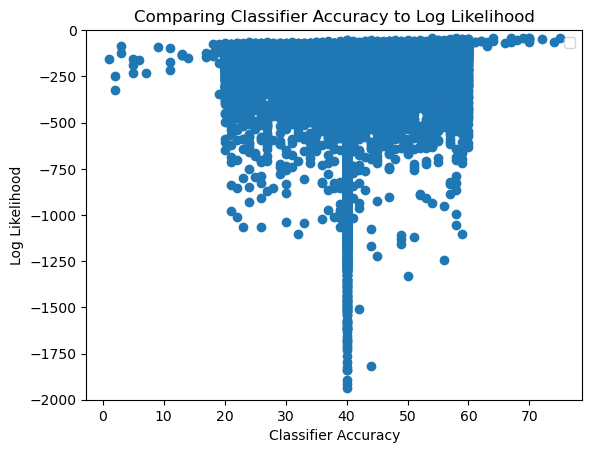

No handles with labels found to put in legend.


PyObject <matplotlib.legend.Legend object at 0x7f4017186ed0>

In [58]:
#----------------
#Test Likelihood
#----------------
function likelihood(best_trace, best_acc, best_score, best_k)
    obs = obs_master;
    obs[(:k,1)] = 2
    (trace,) = generate(classifier, (x,), obs)
    
    pred_y = (G(x, trace))
    pred_labels = data_labeller(pred_y)
    acc = sum([classes[i] == pred_labels[i] for i=1:length(classes)])
    
    #pred_y = [trace[(:y,i)] for i=1:length(classes)]
    #acc = sum([classes[i] == pred_y[i] for i=1:length(classes)])
    score = get_score(trace)
    
    #println(score)
    if acc > best_acc
        best_acc = acc
        best_score = score
        best_trace = trace
        best_pred_y = pred_y
        best_k = best_trace[(:k,1)]
    end
    #push!(best_ks,best_k)
    push!(scores,score)
    push!(accs,acc)
    #push!(ls, l)
    #println(best_score)
    return(best_trace, best_acc, best_score, best_k)
end;

for i=1:10000
    best_trace, best_acc, best_score, best_k = likelihood(best_trace, best_acc, best_score, best_k)
    push!(best_ks, best_k)
end

PyPlot.scatter(accs, scores)
plt.title("Comparing Classifier Accuracy to Log Likelihood")
plt.xlabel("Classifier Accuracy")
plt.ylabel("Log Likelihood")
plt.ylim(-2000,1)
plt.legend()
#print(best_ks)

In [59]:
#-------------------------
#Layer Birth / Death Moves
#-------------------------

function obs_maker(trace)
    obs_new = choicemap()::ChoiceMap
    for i=1:length(classes)
        obs_new[(:y,i)] = classes[i]
    end
    obs_new[:l] = trace[:l]
    return obs_new
end

function node_change(trace)
    current_l = trace[:l]
    layer = rand((1:current_l))
    #println("Proposed layer: $layer")
    current_k = trace[(:k, layer)]
    if current_k == last(k_list)
        new_trace = node_death(trace,layer)
    elseif current_k == k_list[1]
        new_trace = node_birth(trace,layer)
    else
        new_trace = bernoulli(0.5) ? node_birth(trace,layer) : node_death(trace,layer)
    end
    return new_trace        
end

@gen function node_birth(trace, layer)
    
    previous_k = trace[(:k,layer)]
    new_k = k_list[previous_k + 1]
    difference = abs(new_k - previous_k)
    
    #Create new choicemap and fill with real Y values
    obs_new = obs_maker(trace)
    obs_new[:l] = trace[:l]
    
    #Fill k values in new ChoiceMap
    for i=1:trace[:l]+1
        if i == layer
            obs_new[(:k,i)] = new_k
        elseif i < layer
            obs_new[(:k,i)] = trace[(:k,i)]
        else
            obs_new[(:k,i)] = trace[(:k,i)]
        end
    end
    
    (new_trace, weight) = generate(classifier, (x,), obs_new)
    return new_trace
end

@gen function node_death(trace, layer)
    
    previous_k = trace[(:k,layer)]
    new_k = k_list[previous_k - 1]
    difference = abs(new_k - previous_k)
    
    #Create new choicemap and fill with real Y values
    obs_new = obs_maker(trace)
    obs_new[:l] = trace[:l]
    
    #Fill k values in new ChoiceMap
    for i=1:trace[:l]+1
        if i == layer
            obs_new[(:k,i)] = new_k
        elseif i < layer
            obs_new[(:k,i)] = trace[(:k,i)]
        else
            obs_new[(:k,i)] = trace[(:k,i)]
        end
    end
    
    (new_trace, weight) = generate(classifier, (x,), obs_new)
    return new_trace
    
end;

In [68]:
#-------------------------
#RJMCMC - Layers and Nodes
#-------------------------
traces = []
acc = []
acc_a = []
acc_w = []
acc_l = []
k_results = []
epss = []

function select_hyperparameters(trace, obs)
    args = get_args(trace)
    argdiffs = map((_) -> NoChange(), args)
    (new_trace,weight,retdiff) = regenerate(trace, args, argdiffs, select(:τ₁,:τ₂,:τ₃))
    obs[:τ₁] = new_trace[:τ₁]
    obs[:τ₂] = new_trace[:τ₂]
    obs[:τ₃] = new_trace[:τ₃]
    return new_trace, obs
end

function select_selection(trace)
    l = trace[:l]
    selection = select()
    for i=1:l+1
        push!(selection, (:W,i))
        push!(selection, (:b,i))
    end
    return selection
end

function within_move(trace, iters, obs)
    for i=1:iters
        eps = uniform(0.01,0.2)
        selection = select_selection(trace)
        (trace, accepted) = hmc(trace, selection, L=1, eps=eps, check=false, observations=obs)
        push!(traces, trace)
        push!(acc, accepted)
        push!(acc_w, accepted)
        #accepted && println("Within accepted")
    end
    return trace
end

function node_move(trace, iters, obs)
    
    #Determine birth or death
    current_l = trace[:l]
    layer = rand((1:current_l))
    current_k = trace[(:k, layer)]
    
    if current_k == last(k_list)
        move_type = 0
    elseif current_k == k_list[1]
        move_type = 1
    else
        move_type = bernoulli(0.5)
    end
    move = "Empty"
    
    if move_type == 1
        #For birth move, first propose birth, then HMC
        move = "Birth"
        new_trace = node_birth(trace, layer)
        score_test = get_score(new_trace)
        selection = select_selection(trace)
        test = true
        for i=1:iters
            eps = uniform(0.1,0.4)
            (new_trace, accepted) = hmc(new_trace, selection, L=10, eps=eps, check=false, observations=obs)
            accepted && push!(epss, eps)
            #accepted && (test = false)
        end
    else
        #For death move, HMC steps come first (Sen and Biswas, 2017)
        move = "Death"
        #new_trace = trace
        new_trace = node_death(trace, layer)
        score_test = get_score(new_trace)
        selection = select_selection(new_trace)
        for i=1:iters
            #new_trace = trace
            eps = uniform(0.1,0.4)
            (new_trace, accepted) = hmc(new_trace, selection, L=10, eps=eps, check=false, observations=obs)
            #accepted && (test = false)
        end
        
        
        test = true
    end
    
    score1 = get_score(trace)
    score2 = get_score(new_trace)
    #println(score1)
    #println(score2)
    
    logscore = (score2 - score1)
    score = exp(logscore)

    #println("$move Old Trace: $score1; Pre-HMC: $score_test; Post-HMC: $score2")
    if rand(Uniform(0,1)) < score
        accepted = true
        trace = new_trace
        new_k = [trace[(:k,i)] for i=1:trace[:l]]
        #println("New ks accepted! Current ks: $(new_k)")
    else
        #println("Sticking with the old k!")
        accepted = false
    end
        
    push!(traces, trace)
    push!(acc, accepted)
    push!(acc_a, accepted)
    return trace
end


function rjmcmc(starting_trace, iters)
    trace = starting_trace
    l = trace[:l]
    ks = [trace[(:k,i)] for i=1:trace[:l]]
    println("Beginning RJMCMC. Starting l: $l")
    println("Starting ks: $ks")
    println("--------------------------------")
    #@showprogress 1 "Sampling..." for i = 1:iters
    for i=1:iters
        l = trace[:l]
        ks = [trace[(:k,i)] for i=1:trace[:l]]
        #x_samp, y_samp = sample_data(x, y_real)
        #x_samp = transpose(x_samp)
        obs_master = choicemap()::ChoiceMap
        for i=1:length(classes)
            obs_master[(:y,i)] = classes[i]
        end
        obs = obs_master;
        if i%500 == 0
            #println("Epoch $i Acceptance Prob: $(sum(acc)/length(acc))")
            #println("Epoch $i layer count: $l, ks: $ks")
            println("Epoch $i Within Acceptance Prob: $(sum(acc_w)/length(acc_w))")
            println("Epoch $i Across Acceptance Prob: $(sum(acc_a)/length(acc_a))")
            #println("Epoch $i Layer Acceptance Prob: $(sum(acc_l)/length(acc_l))")
            println([trace[(:k,i)] for i=1:trace[:l]])
        end
        
        #Gibbs sampling for hyperparameters
        trace, obs = select_hyperparameters(trace, obs)
        
        #Indicator variable for move type
        u = rand(Uniform(0,1))
        if u > 0.5
            (trace) = node_move(trace, 10, obs)
        else
            (trace) = within_move(trace, 1, obs)
        end
        #println(trace[(:k,1)])
        push!(k_results, trace[(:k,1)])
    end
    println("Finished")
end
 
runs = 20000
#starting_trace = best_trace

#x_samp, y_samp = sample_data(x, y_real)
#x_samp = transpose(x_samp)
obs_master = choicemap()::ChoiceMap
for i=1:length(classes)
    obs_master[(:y,i)] = classes[i]
end
obs_master[:l] = 1
obs = obs_master
(starting_trace,) = generate(classifier, (x,), obs)
#starting_trace = best_trace
obs[:l] = starting_trace[:l]

rjmcmc(starting_trace,runs);

Beginning RJMCMC. Starting l: 1
Starting ks: [4]
--------------------------------
Epoch 500 Within Acceptance Prob: 0.6352459016393442
Epoch 500 Across Acceptance Prob: 0.023529411764705882
[2]
Epoch 1000 Within Acceptance Prob: 0.655241935483871
Epoch 1000 Across Acceptance Prob: 0.011928429423459244
[2]
Epoch 1500 Within Acceptance Prob: 0.667107001321004
Epoch 1500 Across Acceptance Prob: 0.008086253369272238
[2]
Epoch 2000 Within Acceptance Prob: 0.655688622754491
Epoch 2000 Across Acceptance Prob: 0.006018054162487462
[2]


InterruptException: InterruptException:

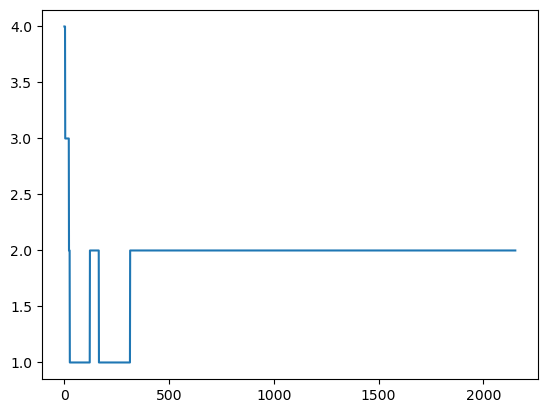

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f4020512a90>

In [69]:
plot(k_results)